Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
####Taking necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#using the data by mounting the google drive
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
!ls

 gdrive       'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [7]:
#Counting the images in train and test datasets
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [9]:
## train dataset
## using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing the images to the size img_height*img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## validation dataset
## using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing the images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Listing out all the classes of skin cancer and store them in a list. 
# we can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### creating a code to visualize one instance of all the nine classes present in the dataset

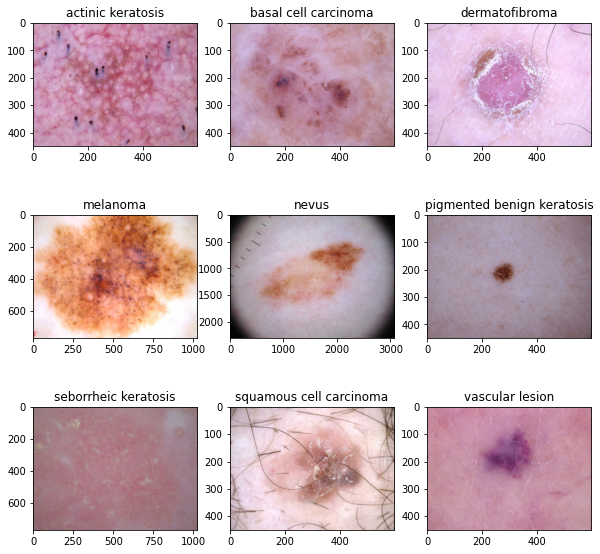

In [12]:
import matplotlib.pyplot as plt

### using training  data to visualize
num_class=9
import matplotlib.image as mpimg
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(num_class):
    ax = plt.subplot(3, 3, i + 1)
    image=mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:

#rescaling and model creation
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class,activation='softmax')
])

### Compile the model


In [15]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
##epoch using 20

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 73ms/step - loss: 2.0775 - accuracy: 0.2628 - val_loss: 1.7035 - val_accuracy: 0.4116
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6573 - accuracy: 0.3934 - val_loss: 1.5885 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5888 - accuracy: 0.4353 - val_loss: 1.6279 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4971 - accuracy: 0.4704 - val_loss: 1.5520 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3540 - accuracy: 0.5206 - val_loss: 1.3432 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2832 - accuracy: 0.5530 - val_loss: 1.4951 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2193 - accuracy: 0.5658 - val_loss: 1.3523 - val_accuracy: 0.5280
Epoch 8/20
5

### Visualizing training results

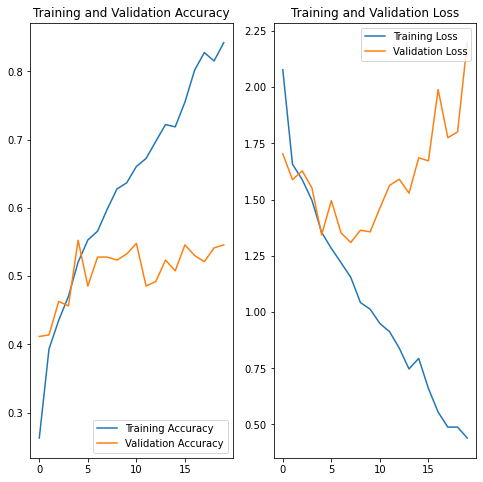

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:There is a huge difference in the accuracy of train and validation data,train accuracy is much high,so it is a sign of overfitting.


In [19]:
# after we have analysed the model fit history for presence of overfit, choosing an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

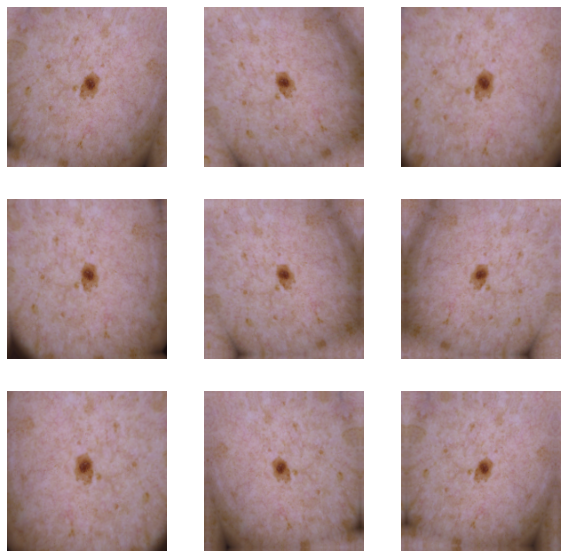

In [20]:
# visualize how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [21]:
## using Dropout layer as there is an evidence of overfitting in our findings


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class,activation='softmax')
])


### Compiling the model

In [22]:
## compiling
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [23]:
## train the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 44ms/step - loss: 2.1670 - accuracy: 0.2327 - val_loss: 1.8466 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6719 - accuracy: 0.4146 - val_loss: 1.6022 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5142 - accuracy: 0.4654 - val_loss: 1.4453 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4223 - accuracy: 0.4994 - val_loss: 1.4024 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3460 - accuracy: 0.5307 - val_loss: 1.3484 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2827 - accuracy: 0.5474 - val_loss: 1.4168 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3005 - accuracy: 0.5474 - val_loss: 1.4107 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing the results

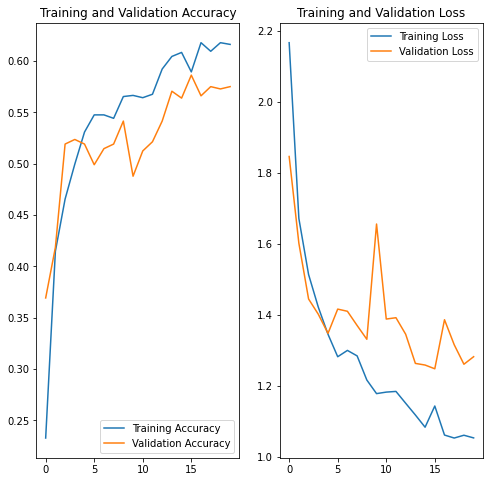

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:there is difference between previous model and this model.Now the difference in model accuracy for train and validation is low.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
#Creating a dataframe for train dataset
from glob import glob
path_list_2 = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_2
lesion_list_2 = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_2
dataframe_dict_old = dict(zip(path_list_2, lesion_list_2))
df1 = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

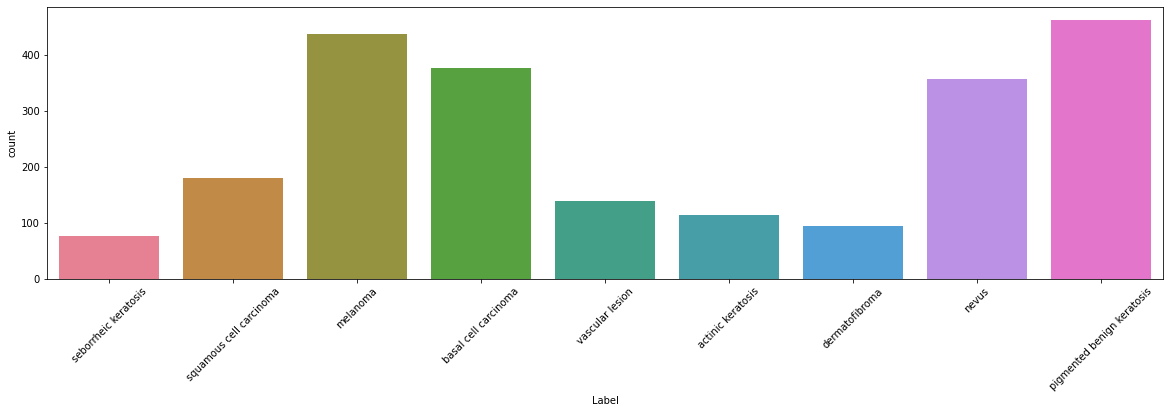

In [26]:

#Visualizing class distribution in train data

import seaborn as sns
plt.figure(figsize=(20,5))
plot = sns.countplot(x="Label",data=df1, palette='husl')
plt.xticks(rotation=45)
plt.show()

#### Observation:There is class imblance in data 
#### - Which class has the least number of samples? 
Ans:Seborrheic keratatosis has least number of samples in training data.
#### - Which classes dominate the data in terms proportionate number of samples?
Ans:Pigmented benign keratosis class is most dominating class in this dataset.After this class, melanoma class comes.

#### Rectifing the class imbalance
#### **Context:** We can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F63B3B4FE80>: 100%|██████████| 500/500 [00:19<00:00, 25.57 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F63B22364F0>: 100%|██████████| 500/500 [00:20<00:00, 24.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6430FB6C10>: 100%|██████████| 500/500 [00:17<00:00, 28.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F63B3ABB580>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F63B3B4A3A0>: 100%|██████████| 500/500 [01:16<00:00,  6.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63B3A78550>: 100%|██████████| 500/500 [00:16<00:00, 29.81 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F63B3B413D0>: 100%|██████████| 500/500 [00:39<00:00, 12.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F63CC58A160>: 100%|██████████| 500/500 [00:16<00:00, 29.79 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F645EB8EE20>: 100%|██████████| 500/500 [00:20<00:00, 24.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_cf3284dd-fd48-4e3e-8986-5ca4db02fe65.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_7f4045c7-e5ea-4c7e-919d-4a885da2f8e2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010912.jpg_e3ab516c-4bee-4623-9550-ec899317cf92.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010872.jpg_ad46c242-ae52-472b-94db-33159b18f158.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010977.jpg_a3c02f01-b14d-4c8a-a70b-8ff4e21a506e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaborat

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
##Appending original training data and augmented data
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df1.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model ( included normalization)

In [38]:

#rescaling and model creation
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_class,activation='softmax')
])

#### Compile the model 

In [39]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Train the model

In [40]:
epochs = 30

#model fitting for 30 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 197ms/step - loss: 1.9971 - accuracy: 0.2431 - val_loss: 1.4807 - val_accuracy: 0.4395
Epoch 2/30
169/169 [==============================] - 25s 141ms/step - loss: 1.4582 - accuracy: 0.4488 - val_loss: 1.3679 - val_accuracy: 0.4774
Epoch 3/30
169/169 [==============================] - 25s 141ms/step - loss: 1.2344 - accuracy: 0.5423 - val_loss: 1.1639 - val_accuracy: 0.5739
Epoch 4/30
169/169 [==============================] - 26s 148ms/step - loss: 1.0563 - accuracy: 0.6181 - val_loss: 1.0285 - val_accuracy: 0.6169
Epoch 5/30
169/169 [==============================] - 25s 141ms/step - loss: 0.9031 - accuracy: 0.6704 - val_loss: 0.9083 - val_accuracy: 0.6555
Epoch 6/30
169/169 [==============================] - 25s 141ms/step - loss: 0.7600 - accuracy: 0.7216 - val_loss: 0.7939 - val_accuracy: 0.7105
Epoch 7/30
169/169 [==============================] - 25s 142ms/step - loss: 0.5973 - accuracy: 0.7854 - val_loss: 0.9133 - val_ac

####  Visualize the model results

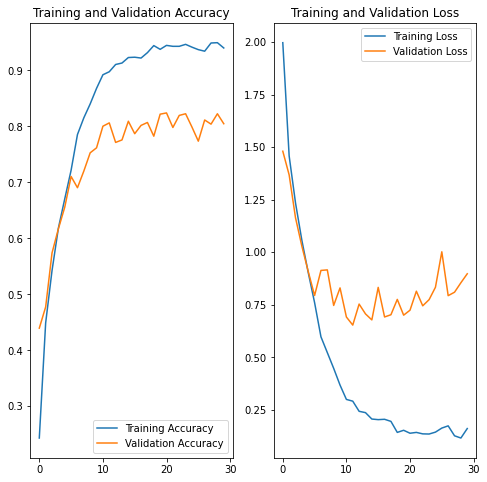

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:Yes rebalacing helped.Now the difference between train and validation accuracy is low and also validation accuracy is good now.Now there is no evidence of overfiting because both accuracies are good and  close. 

